# SIA flow model with drone DEM

In [1]:
base_path = '/eejit/home/bezu0001/'
shapefile_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
dem_path = base_path + 'field_data/drone/dems/Luggye_2025.tif'
old_dem_path = base_path + 'data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif'
thickness_path = base_path + 'data/thickness/farinotti_model_2/thickness_RGI60-15.02373.tif'
img_path = base_path + f'data/satellite_images/luggye_catchment.tiff'

In [2]:
from affine import Affine
from firedrake import *
from firedrake.pyplot import triplot
import geojson
import geopandas as gpd
import icepack
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.transform import array_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import distance_transform_edt, map_coordinates
from shapely.geometry import LineString, MultiPolygon, Polygon, shape, mapping
from shapely.ops import unary_union
import tqdm

## Load RGI outline

In [3]:
gdf = gpd.read_file(shapefile_path)
g = gdf[gdf["rgi_id"].str.contains("15-09534")].geometry.iloc[0]

## Load drone DEM and crop to the RGI ice mask

The drone data includes sidewalls, which we don't want to model. By cropping to the RGI extent we can exclude this. However, the RGI provides a more advanced geometry than the more recent drone data. Therefore, we will also nan out any values below the current terminus elevation (manually determined to be about 4500 m). This way, we do not model the part of the domain that is now just lake water. 

In [4]:
# 1. Target CRS from your RGI outlines (metres-based UTM)
dst_crs = gdf.estimate_utm_crs()

# 2. Load + clip DEM in one pass
with rasterio.open(dem_path) as src:
    src_crs = src.crs
    
    dem, transform = mask(
        src,
        [g],
        crop=True,
        filled=True,
        nodata=np.nan,
        indexes=1,
    )

dem = dem.astype(np.float64)
dem[dem < 4500] = np.nan #exclude the proglacila lake

# 3. Correct bounding box of the *clipped* DEM
left, bottom, right, top = rasterio.transform.array_bounds(
    dem.shape[0], dem.shape[1], transform
)

# 4. Compute UTM transform + output shape
transform_utm, W_utm, H_utm = calculate_default_transform(
    src_crs, dst_crs,
    dem.shape[1], dem.shape[0],
    left, bottom, right, top
)

dem_utm = np.full((H_utm, W_utm), np.nan, dtype=np.float64)

reproject(
    source=dem,
    destination=dem_utm,
    src_transform=transform,
    src_crs=src_crs,
    dst_transform=transform_utm,
    dst_crs=dst_crs,
    resampling=Resampling.nearest,     # <-- change here
    src_nodata=np.nan,
    dst_nodata=np.nan,
)

# Replace with projected DEM + transform (metres)
dem = dem_utm
transform = transform_utm

skip = 2 #make coarser for plotting efficiency
dem = dem[::skip, ::skip]
transform = transform * Affine.scale(skip, skip)

## Get the outline of the region for which we have data

This outline captures the subset of the domain that is (1) within the RGI outline, (2) within the drone DEM, and (3) above the lake level. This is the only part we want to model.  

In [5]:
valid = ~np.isnan(dem)

polys = [
    shape(geom)
    for geom, val in shapes(valid.astype(np.uint8), mask=valid, transform=transform)
    if val == 1
]

outline = unary_union(polys).buffer(0)
if isinstance(outline, MultiPolygon):
    outline = max(outline.geoms, key=lambda p: p.area)

outline = outline.simplify(10.0, preserve_topology=True)

# Split boundary up into distinct segments (for applying BCs later)

By default we'll get a single boundary. Instead, we manually split the boundary into a unique segment for each part of the outline's PolyLine. This is overkill but will do until I figure out a smarter way. 

In [6]:
coords = list(outline.exterior.coords)
M = len(coords) - 1      # number of edges

segments = []

for i in range(M):
    seg = LineString([coords[i], coords[i+1]])
    segments.append({"id": i+1, "geometry": seg})

segments_gdf = gpd.GeoDataFrame(segments, geometry="geometry", crs=gdf.crs)


## Mesh the domain

In [7]:
# Convert segmented boundary into GeoJSON
segments_json = geojson.loads(segments_gdf.to_json())

# Generate a mesh with one Physical Line per segment
gmsh_mesh = icepack.meshing.collection_to_gmsh(segments_json)
gmsh_mesh.write(base_path + "lugge_segments.msh", verbose=False)

# Load into Firedrake
mesh = Mesh(base_path + "lugge_segments.msh")

# (Optional) refine once
mh = MeshHierarchy(mesh, 1)
mesh = mh[-1]

# Function spaces
Q = FunctionSpace(mesh, "CG", 1)
V = VectorFunctionSpace(mesh, "CG", 1)
x, y = firedrake.SpatialCoordinate(Q)


PETSc Error --- Application was linked against both OpenMPI and MPICH based MPI libraries and will not run correctly


## Project data onto the mesh

Using Farinotti bed number 2 (not ensemble) since this bed elevation gives us a present terminus thickness close to the correct value. However, all Farinotti beds, including the ensemble, lie ABOVE the present glacier surface in many locations. See below... 

In [8]:
dist, idx = distance_transform_edt(~valid, return_indices=True)
dem = dem[tuple(idx)]

invT = ~transform
coords = mesh.coordinates.dat.data_ro[:]
col, row = invT * (coords[:,0], coords[:,1])

s_vals = map_coordinates(dem, [row, col], order=1, mode="nearest")

s = Function(Q)
s.dat.data[:] = s_vals


#read Farinotti thickness 

with rasterio.open(thickness_path) as src:
    thick = src.read(1).astype(float)
    thick[thick == src.nodata] = np.nan
    T = src.transform

valid = ~np.isnan(thick)
dist, idx = distance_transform_edt(~valid, return_indices=True)
thick = thick[tuple(idx)]

invT = ~T
coords = mesh.coordinates.dat.data_ro
col, row = invT * (coords[:,0], coords[:,1])

thick_vals = map_coordinates(thick, [row, col], order=1, mode="nearest")

H = Function(Q);  H.dat.data[:] = thick_vals

#now read Farinotti-corresponding DEM to infer bed elevation

with rasterio.open(old_dem_path) as src:
    dem_old = src.read(1).astype(float)
    dem_old[dem_old == src.nodata] = np.nan
    T = src.transform

valid = ~np.isnan(dem_old)
dist, idx = distance_transform_edt(~valid, return_indices=True)
dem_old = dem_old[tuple(idx)]

invT = ~T
coords = mesh.coordinates.dat.data_ro
col, row = invT * (coords[:,0], coords[:,1])

dem_vals = map_coordinates(dem_old, [row, col], order=1, mode="nearest")

s_0 = Function(Q);  s_0.dat.data[:] = dem_vals
# s.project(s_0) #uncomment this line to use the Farinotti surface elevation instead of the drone DEM
#and set all remaining varibles 

b = Function(Q).project(s_0 - H) #farinotti ensemble bed
H = Function(Q).project(s - b) #overrwrite H to reflect current thickness, given drone DEM and Farinotti bed
u = Function(V)
u.interpolate(as_vector((1e-10, 1e-10)))
u_0 = u.copy()
opts = {}

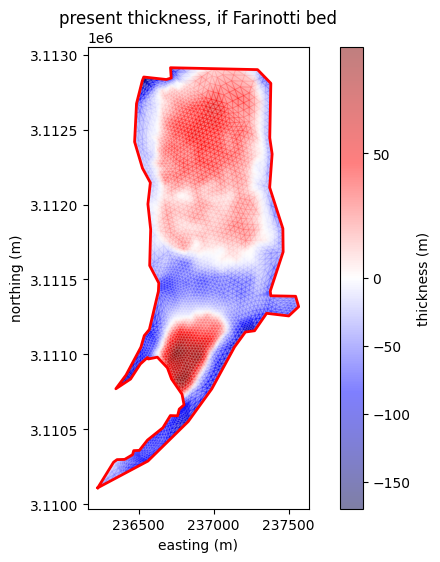

In [9]:
norm = TwoSlopeNorm(vcenter=0)

fig, ax = plt.subplots(figsize=(8,6))

thickness_plot = tripcolor(H, axes=ax, alpha = 0.5, cmap="seismic", norm=norm)
ax.set_title('present thickness, if Farinotti bed')
ox, oy = outline.exterior.xy
ax.plot(ox, oy, 'r-', linewidth=2)
fig.colorbar(thickness_plot, ax=ax, label="thickness (m)")
ax.set_aspect("equal")
ax.set_xlabel('easting (m)')
ax.set_ylabel('northing (m)')
plt.show()

## Fix it by clamping the thickness to a minimum value

For now. 

In [10]:
H.project(max_value(Constant(10), H))
b.project(s - H);

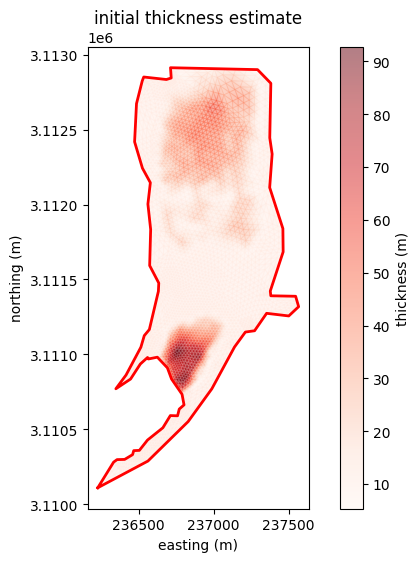

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
thickness_plot = tripcolor(H, axes=ax, alpha = 0.5, cmap="Reds")
# Add outline
ox, oy = outline.exterior.xy
ax.plot(ox, oy, 'r-', linewidth=2)
ax.set_title('initial thickness estimate')
fig.colorbar(thickness_plot, ax=ax, label="thickness (m)")
ax.set_aspect("equal")
ax.set_xlabel('easting (m)')
ax.set_ylabel('northing (m)')

plt.show()

## Identify terminus boundary (for applying DBCs)

Manually choose some test IDs, corresponding to outline segments. The plot will show which mesh nodes fall on those segments. Identify your desired boundary IDs by brute force, until I think of a smarter way... 

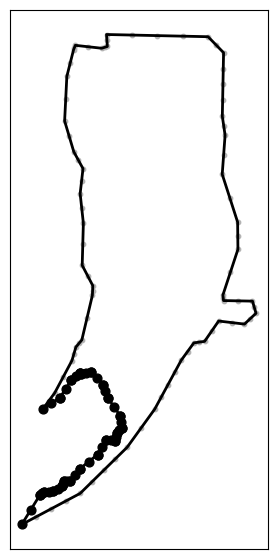

In [12]:
# try a few IDs manually
test_ids = list(range(1, 22))  #manually toggle through some different ranges


coords = mesh.coordinates.dat.data_ro
valid_ids = list(mesh.exterior_facets.unique_markers)  # e.g. [1,2,...,49]

plt.figure(figsize=(7,7))

# outline
ox, oy = outline.exterior.xy
plt.plot(ox, oy, 'k-', linewidth=2)

# all boundary nodes (grey)
bc_all = DirichletBC(Q, 0, "on_boundary")
all_nodes = bc_all.nodes
plt.scatter(coords[all_nodes,0], coords[all_nodes,1], s=10, color="0.7")

# selected boundary IDs (black)
for bid in test_ids:
    bc = DirichletBC(Q, 0, bid)
    nodes = bc.nodes
    plt.scatter(coords[nodes,0], coords[nodes,1], s=40, color="k")

plt.xticks([])
plt.yticks([])

plt.gca().set_aspect("equal")
plt.show()

In [13]:
terminus_ids = test_ids
all_ids = list(mesh.exterior_facets.unique_markers)
other_ids = list(set(all_ids) - set(terminus_ids))


opts = {
    'dirichlet_ids' : other_ids,
}

## Forward model with icepack!

In [14]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

In [15]:
Δt = 1/2
num_years = 10
num_timesteps = int(num_years/Δt)

for step in tqdm.trange(num_timesteps):
    
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H, accumulation = Constant(0))
    s.project(b + H)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.38it/s]


## Optional: plot over top of satellite image

In [16]:
# --- 1. Load original satellite image (lat/lon) ---
with rasterio.open(img_path) as src:
    sat = src.read()
    src_crs = src.crs
    src_transform = src.transform

# --- 2. Compute UTM transform ---
transform_utm, W_utm, H_utm = calculate_default_transform(
    src_crs, dst_crs,
    src.width, src.height,
    *src.bounds
)

# --- 3. Allocate output array ---
sat_utm = np.zeros((sat.shape[0], H_utm, W_utm), dtype=sat.dtype)

# --- 4. Reproject each band ---
for i in range(sat.shape[0]):
    reproject(
        source=sat[i],
        destination=sat_utm[i],
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=transform_utm,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
    )

# --- 5. Compute correct extent for plotting ---
minx, miny, maxx, maxy = array_bounds(H_utm, W_utm, transform_utm)
extent = (minx, maxx, miny, maxy)

# --- 6. Convert (bands, H, W) → (H, W, bands) ---
rgb = np.moveaxis(sat_utm, 0, -1)


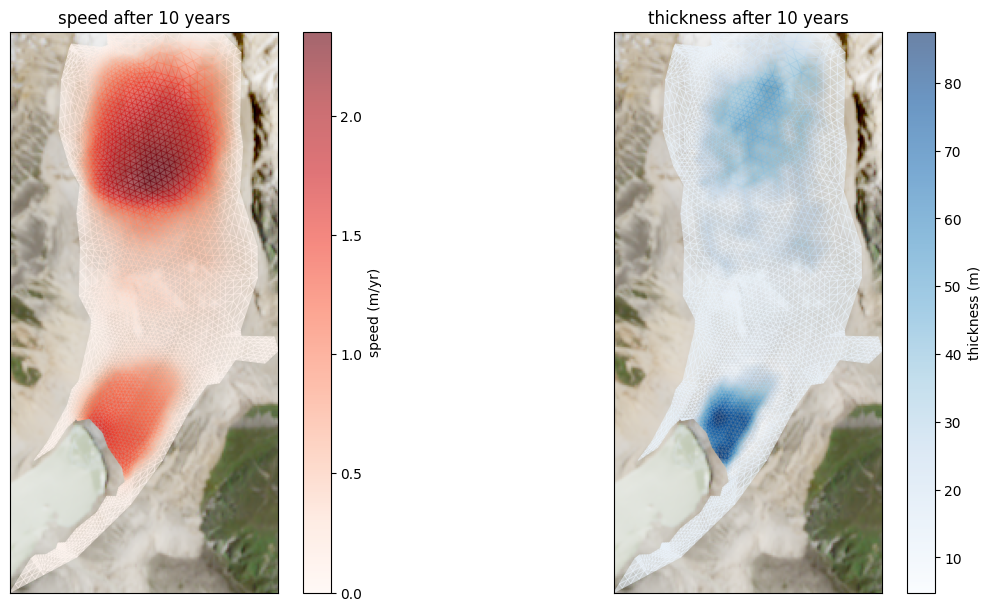

In [17]:
modeled_speed = Function(Q).project(sqrt(u[0]**2 + u[1]**2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

ax1.set_title(f"speed after {num_years} years")
ax1.set_aspect('equal')
ax1.imshow(rgb, extent=extent, origin="upper")
speed_plot = tripcolor(modeled_speed, axes=ax1, cmap='Reds', alpha=0.6)
fig.colorbar(speed_plot, ax=ax1, label="speed (m/yr)")

# clip to mesh domain
ax1.set_xlim(mesh.coordinates.dat.data_ro[:,0].min(),
             mesh.coordinates.dat.data_ro[:,0].max())
ax1.set_ylim(mesh.coordinates.dat.data_ro[:,1].min(),
             mesh.coordinates.dat.data_ro[:,1].max())

ax2.set_title(f"thickness after {num_years} years")
ax2.set_aspect('equal')
ax2.imshow(rgb, extent=extent, origin="upper")
thickness_plot = tripcolor(H, axes=ax2, cmap='Blues', alpha=0.6)
fig.colorbar(thickness_plot, ax=ax2, label="thickness (m)")

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()